In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3


In [2]:
# Questo script forrebbe ricreare il profilo di un dente con dentatura ad evolvente. 
# Per farlo ho preso a larghe mani spunto dall'articolo "A Mathematical Model for Parametric Tooth Profile of Spur Gears" 
# Che per brevità d'ora in poi chiamerò Articolo1. 
# Questo articolo definisce le funzioni matematiche di seguito indicate

# Funzione evolvente
def ev(angolo):
    return np.tan(angolo) - angolo

# Creazione del profilo ad evolvente 
def coordinate_x(alpha_t, rb, z, ry):
    """
    Funzione per il calcolo delle coordinate x del dente. 

    Args: 
        alpha_t: is the pressure angle
        rb: radius of the base circle (fondamentale)
        z: numero  di denti
        ry: radius of any circle (variabile)

    Returns: 
        x, y: coordinate per plottare il profilo del dente
    """
    alpha_t = np.radians(alpha_t)
    inv_at = ev(alpha_t)
    alpha_y = np.arccos(rb/ry)
    inv_ay = ev(alpha_y)
    frac = np.pi/(2*z)
    sin_value = np.sin(frac + inv_at - inv_ay)

    x = ry*sin_value
    return x

def coordinate_y(alpha_t, rb, z, ry):
    """
    Funzione per il calcolo delle coordinate y del dente. 

    Args: 
        alpha_t: is the pressure angle
        rb: radius of the base circle (fondamentale)
        z: numero  di denti
        ry: radius of any circle (variabile)

    Returns: 
        x, y: coordinate per plottare il profilo del dente
    """   
    alpha_t = np.radians(alpha_t)
    inv_at = ev(alpha_t)
    alpha_y = np.arccos(rb/ry)
    inv_ay = ev(alpha_y)
    frac = np.pi/(2*z)
    cos_value = np.cos(frac + inv_at - inv_ay)

    y = ry*cos_value
    return y

In [3]:
# Ora inizializzo i parametri della ruota dentata progettata.
# Angolo d'elica: nullo, angolo di pressione: 20grad, 
# Parametri della ruota dentata - SOPRA PRIMITIVA
####    VALORI GLOBALI
vg_path = "database/variabili_globali.db"
# Connessione
conn = sqlite3.connect(vg_path)
cur = conn.cursor()
cur.execute("SELECT valori FROM variabili_globali")
vg = [row[0] for row in cur.fetchall()]
theta_p = vg[0]                                       # Angolo di pressione
alpha = np.degrees(theta_p)
DentiP = vg[1]
DentiR = vg[2]                                        # Numero di denti di pignone e ruota
tau_re = vg[3]                                # Reale rapporto di trasmissione
m = vg[4]                                             # modulo e addendum
a = m
beta = 0  
conn.close()




####    CARATTERISTICHE GEOMETRICHE NON CORRETTE
cnc_path = "database/caratteristiche_nc.db"
conn = sqlite3.connect(cnc_path)
#   PIGNONE
cur1 = conn.cursor()
cur1.execute("SELECT pignone FROM caratteristiche_nc")
cncP = [row[0] for row in cur1.fetchall()]
#   RUOTA
cur2 = conn.cursor()
cur2.execute("SELECT ruota FROM caratteristiche_nc")
cncR = [row[0] for row in cur2.fetchall()]
####    Pignone
r_pignone = cncP[0]     # Primitiva
rho_pignone = cncP[1]   # Fondamentale
ra_p = cncP[2]          # Testa
rp_p = cncP[3]          # Piede
####    Ruota
r_ruota = cncR[0]       # Primitiva
rho_ruota = cncR[1]     # Fondamentale
ra_r = cncR[2]          # Testa
rp_r = cncR[3]          # Piede
conn.close()









####    POST-CORREZIONE: Valori & Dimensioni
pc_path = "database/post_correzione.db"
conn = sqlite3.connect(pc_path)
#   PIGNONE
cur1 = conn.cursor()
cur1.execute("SELECT pignone FROM post_correzione")
pcP = [row[0] for row in cur1.fetchall()]
#   RUOTA
cur2 = conn.cursor()
cur2.execute("SELECT ruota FROM post_correzione")
pcR = [row[0] for row in cur2.fetchall()]
####    pignone&ruota
x_p, x_r = pcP[0], pcR[0]                           # fattori correttivi di ruota e pignone
theta_l = pcP[1]                                    # [rad] angolo di lavoro
thetal = np.degrees(theta_l)                        # [grad]
raggio_corretto_pignone = pcP[6]              # [mm] primitiva
raggio_corretto_ruota = pcR[6]                # [mm] primitiva
diametro_t_p = pcP[7]                             # [mm] raggio di testa pignone
diametro_t_r = pcR[7]                             # [mm] raggio di testa ruota
diametro_pp_p = pcP[8]                            # [mm] raggio di piede pignone
diametro_pp_r = pcR[8]                            # [mm] raggio di piede ruota           
conn.close()


In [4]:

# INIZIALIZZAZIONE VARIABILI PIGNONE
r_bP = rho_pignone      # Raggio di base PIGNONE (fondamentale)
R_minP = r_bP           # Raggio minimo PIGNONE  (fondamentale)
R_maxP = ra_p           # Raggio massimo PIGNONE (testa)
R_valoriP = np.arange(R_minP, R_maxP, 0.001)



# iNIZIALIZZAZIONE VARIABILI RUOTA
r_bR = rho_ruota        # Raggio di base RUOTA (fondamentale)
R_minR = r_bR           # Raggio minimo RUOTA  (fondamentale)
R_maxR = ra_r           # Raggio massimo RUOTA (testa)
R_valoriR = np.arange(R_minR, R_maxR, 0.001)

In [5]:
####    PIGNONE
# Coordonate del profilo
xP = np.array([coordinate_x(alpha, r_bP, DentiP, rr) for rr in R_valoriP])
yP = np.array([coordinate_y(alpha, r_bP, DentiP, rr) for rr in R_valoriP])

# Archi che individuano la circonerenza primitiva, quella fondamentale e quella di piede
angolo1 = np.linspace(1.74533, 1.39626, 100)
# Primitiva
arc_x_primP = r_pignone * np.cos(angolo1)
arc_y_primP = r_pignone * np.sin(angolo1)
# Fondamentale
arc_x_fondP = rho_pignone * np.cos(angolo1)
arc_y_fondP = rho_pignone * np.sin(angolo1)
# Di piede
arc_x_piedP = rp_p * np.cos(angolo1)
arc_y_piedP = rp_p * np.sin(angolo1)
# Valori Che individuano la spoglia superiore, la testa del dente
x_tip_plotP = np.sqrt(R_maxP**2 - R_valoriP**2)
y_tip_plotP= np.sqrt(R_maxP**2 - xP**2)

In [6]:
####    RUOTA
# Coordonate del profilo
xR = np.array([coordinate_x(alpha, r_bR, DentiR, aa) for aa in R_valoriR])
yR = np.array([coordinate_y(alpha, r_bR, DentiR, aa) for aa in R_valoriR])

# Archi che individuano la circonerenza primitiva, quella fondamentale e quella di piede
angolo2 = np.linspace(1.65806, 1.48353, 100)
# Primitiva
arc_x_primR = r_ruota * np.cos(angolo2)
arc_y_primR = r_ruota * np.sin(angolo2)
# Fondamentale
arc_x_fondR = rho_ruota * np.cos(angolo2)
arc_y_fondR = rho_ruota * np.sin(angolo2)
# Di piede
arc_x_piedR = rp_r * np.cos(angolo2)
arc_y_piedR = rp_r * np.sin(angolo2)
# Valori Che individuano la spoglia superiore, la testa del dente
x_tip_plotR = np.sqrt(R_maxR**2 - R_valoriR**2)
y_tip_plotR= np.sqrt(R_maxR**2 - xR**2)

CONTROLLO GRAFICO: SPESSORE IN TESTA PIGNONE 1.78
CONTROLLO GRAFICO: SPESSORE IN TESTA RUOTA 1.95


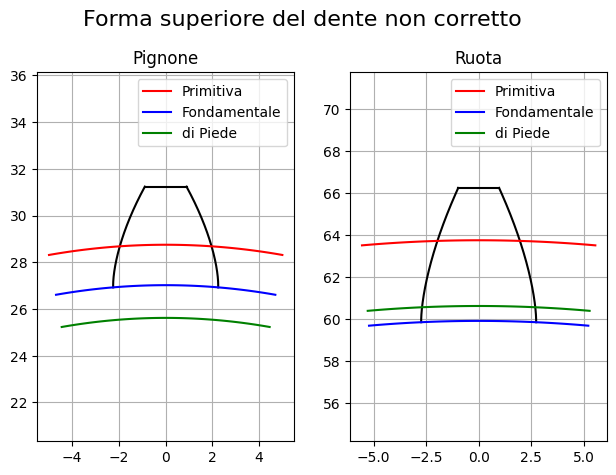

In [7]:
fig, axs = plt.subplots(1, 2)
####    Plot sopra primitiva, pignone
# Profilo dx & sx sopra primitiva
#plt.figure(1)
axs[0].plot(xP, yP, 'k') 
axs[0].plot(-xP, yP, 'k')
# Circonferenze caratteristiche
axs[0].plot(arc_x_primP, arc_y_primP, 'r', label='Primitiva')
axs[0].plot(arc_x_fondP, arc_y_fondP, 'b', label='Fondamentale')
axs[0].plot(arc_x_piedP, arc_y_piedP, 'g', label='di Piede')
axs[0].legend(loc='upper right')
# Testa del dente
axs[0].plot([-xP[-1], xP[-1]], [y_tip_plotP[-1], y_tip_plotP[-1]], 'k')
# Ammennicoli 
axs[0].set_title('Pignone')
axs[0].grid(True)
axs[0].axis('equal')
####    Plot sopra primitiva, ruota 
axs[1].plot(xR, yR, 'k') 
axs[1].plot(-xR, yR, 'k')
# Circonferenze caratteristiche
axs[1].plot(arc_x_primR, arc_y_primR, 'r', label='Primitiva')
axs[1].plot(arc_x_fondR, arc_y_fondR, 'b', label='Fondamentale')
axs[1].plot(arc_x_piedR, arc_y_piedR, 'g', label='di Piede')
axs[1].legend(loc='upper right')
# Testa del dente
axs[1].plot([-xR[-1], xR[-1]], [y_tip_plotR[-1], y_tip_plotR[-1]], 'k')
# Ammennicoli 
axs[1].set_title('Ruota')
axs[1].grid(True)
axs[1].axis('equal') 

fig.suptitle('Forma superiore del dente non corretto', fontsize=16)
plt.tight_layout()  
plt.savefig('plotdenti_NC.png', dpi=300) 


print("CONTROLLO GRAFICO: SPESSORE IN TESTA PIGNONE", round(xP[-1] + np.abs(xP[-1]),2))
print("CONTROLLO GRAFICO: SPESSORE IN TESTA RUOTA", round(xR[-1] + np.abs(xR[-1]),2))

In [8]:
####    CORREZIONE
# INIZIALIZZAZIONE VARIABILI PIGNONE CORRETTE
R_maxP_C = diametro_t_p           # Raggio massimo PIGNONE (testa)
R_valoriP_C = np.arange(R_minP, R_maxP_C, 0.001)



# INIZIALIZZAZIONE VARIABILI RUOTA
R_maxR_C = diametro_t_r           # Raggio massimo RUOTA (testa)
R_valoriR_C = np.arange(R_minR, R_maxR_C, 0.001)

In [9]:
####    PIGNONE
# Coordonate del profilo
xP_C = np.array([coordinate_x(thetal, r_bP, DentiP, bb) for bb in R_valoriP_C]) #o alphal?
yP_C = np.array([coordinate_y(thetal, r_bP, DentiP, bb) for bb in R_valoriP_C])

# Archi che individuano la circonerenza primitiva, quella fondamentale e quella di piede
# Primitiva
arc_x_primP_C = raggio_corretto_pignone * np.cos(angolo1)
arc_y_primP_C = raggio_corretto_pignone * np.sin(angolo1)
# Di piede
arc_x_piedP_C = diametro_pp_p * np.cos(angolo1)
arc_y_piedP_C = diametro_pp_p * np.sin(angolo1)
# Valori Che individuano la spoglia superiore, la testa del dente
y_tip_plotP_C= np.sqrt(R_maxP_C**2 - xP_C**2)

In [10]:
####    RUOTA
# Coordonate del profilo
xR_C = np.array([coordinate_x(thetal, r_bR, DentiR, cc) for cc in R_valoriR_C])
yR_C = np.array([coordinate_y(thetal, r_bR, DentiR, cc) for cc in R_valoriR_C])

# Archi che individuano la circonerenza primitiva, quella fondamentale e quella di piede
# Primitiva
arc_x_primR_C = raggio_corretto_ruota * np.cos(angolo2)
arc_y_primR_C = raggio_corretto_ruota * np.sin(angolo2)
# Di piede
arc_x_piedR_C = diametro_pp_r * np.cos(angolo2)
arc_y_piedR_C= diametro_pp_r * np.sin(angolo2)
# Valori Che individuano la spoglia superiore, la testa del dente
y_tip_plotR_C= np.sqrt(R_maxR_C**2 - xR_C**2)

CONTROLLO GRAFICO: SPESSORE IN TESTA PIGNONE CORRETTO 1.27
CONTROLLO GRAFICO: SPESSORE IN TESTA RUOTA CORRETTO 2.18


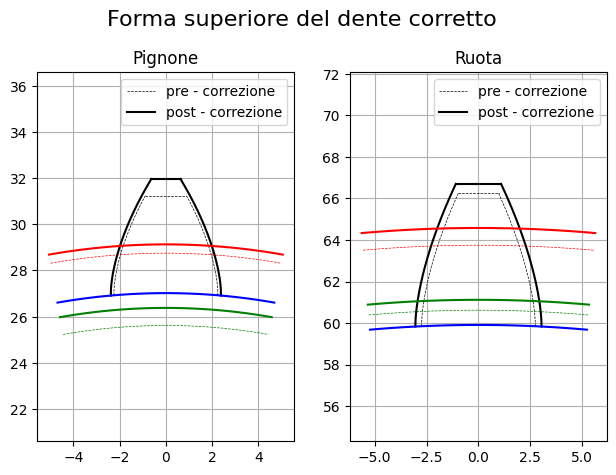

In [11]:
fig, axs = plt.subplots(1, 2)

# Plot sopra primitiva, pignone
# Profilo dx & sx sopra primitiva
# NON CORRETTO
axs[0].plot(xP, yP, 'k--', linewidth=0.5) 
axs[0].plot(-xP, yP, 'k--', linewidth=0.5)
# Circonferenze caratteristiche
axs[0].plot(arc_x_primP, arc_y_primP, 'r--', linewidth=0.5)
axs[0].plot(arc_x_fondP, arc_y_fondP, 'b--', linewidth=0.5)
axs[0].plot(arc_x_piedP, arc_y_piedP, 'g--', linewidth=0.5)
# Testa del dente
axs[0].plot([-xP[-1], xP[-1]], [y_tip_plotP[-1], y_tip_plotP[-1]], 'k--', linewidth=0.5, label = "pre - correzione")
# CORRETTO
axs[0].plot(xP_C, yP_C, 'k') 
axs[0].plot(-xP_C, yP_C, 'k')
# Circonferenze caratteristiche
axs[0].plot(arc_x_primP_C, arc_y_primP_C, 'r')
axs[0].plot(arc_x_fondP, arc_y_fondP, 'b')
axs[0].plot(arc_x_piedP_C, arc_y_piedP_C, 'g')
# Testa del dente
axs[0].plot([-xP_C[-1], xP_C[-1]], [y_tip_plotP_C[-1], y_tip_plotP_C[-1]],'k',label = "post - correzione")
axs[0].legend(loc='upper right')
# Ammennicoli 
axs[0].set_title('Pignone')
axs[0].grid(True)
axs[0].axis('equal')

# Plot sopra primitiva, ruota 
# NON CORRETTO
axs[1].plot(xR, yR, 'k--', linewidth=0.5) 
axs[1].plot(-xR, yR, 'k--', linewidth=0.5)
# Circonferenze caratteristiche
axs[1].plot(arc_x_primR, arc_y_primR, 'r--', linewidth=0.5)
axs[1].plot(arc_x_fondR, arc_y_fondR, 'b--', linewidth=0.5)
axs[1].plot(arc_x_piedR, arc_y_piedR, 'g--', linewidth=0.5)
# Testa del dente
axs[1].plot([-xR[-1], xR[-1]], [y_tip_plotR[-1], y_tip_plotR[-1]], 'k--', linewidth=0.5, label = "pre - correzione")
# CORRETTO
axs[1].plot(xR_C, yR_C, 'k') 
axs[1].plot(-xR_C, yR_C, 'k')
# Circonferenze caratteristiche
axs[1].plot(arc_x_primR_C, arc_y_primR_C, 'r')
axs[1].plot(arc_x_fondR, arc_y_fondR, 'b')
axs[1].plot(arc_x_piedR_C, arc_y_piedR_C, 'g')
# Testa del dente
axs[1].plot([-xR_C[-1], xR_C[-1]], [y_tip_plotR_C[-1], y_tip_plotR_C[-1]], 'k', label = "post - correzione")
axs[1].legend(loc='upper right')

# Ammennicoli 
axs[1].set_title('Ruota')
axs[1].grid(True)
axs[1].axis('equal') 

fig.suptitle('Forma superiore del dente corretto', fontsize=16)
plt.tight_layout()  
plt.savefig('plotdenti_C.png', dpi=300)


print("CONTROLLO GRAFICO: SPESSORE IN TESTA PIGNONE CORRETTO", round(xP_C[-1] + np.abs(xP_C[-1]),2))
print("CONTROLLO GRAFICO: SPESSORE IN TESTA RUOTA CORRETTO", round(xR_C[-1] + np.abs(xR_C[-1]),2))
plt.show()